# Algorithm selection, grid search, cross validation, multiclass classification, one-class classification, imbalanced data, and model selection.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import mixture

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, linear_model, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics

# from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
#                              accuracy_score, roc_auc_score, RocCurveDisplay)

from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler

## 1. Algorithm selection for multiclass classification by optical recognition of handwritten digits

The [digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) dataset
  has 1797 labeled images of hand-written digits.
  - $X$ = `digits.data` has shape (1797, 64).
    - Each image $\mathbf{x}_i$ is represented as the $i$th row of 64 pixel values in the 2D
      `digits.data` array that corresponds to an 8x8 photo of a handwritten digit.
  - $y$ = `digits.target` has shape (1797,). Each $y_i$ is a number from 0 to 9 indicating
    the handwritten digit that was photographed and stored in $\mathbf{x}_i$.



In [2]:
# ... your code here ...
digits = datasets.load_digits()

X = digits.data
y = digits.target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0, stratify=y_temp)

## Use algorithm selection on training and validation data to choose a best classifier.
Loop through these four classifiers and corresponding parameters, doing a grid search
to find the best hyperparameter setting. Use only the training data for the grid search.
- SVM:
  - Try all values of `kernel` in 'linear', 'rbf'.
  - Try all values of `C` in 0.01, 1, 100.
- logistic regression:
  - Use `max_iter=5000` to avoid a nonconvergence warning.
  - Try all values of `C` in 0.01, 1, 100.
- ID3 decision tree:
  - Use `criterion='entropy` to get our ID3 tree.
  - Try all values of `max_depth` in 1, 3, 5, 7.
- kNN:
  - (Use the default Euclidean distance).
  - Try all values of `n_neighbors` in 1, 2, 3, 4.

- Make a list of the four classifiers without setting any hyperparameters.
- Make a list of four corresponding parameter dictionaries.
- Loop through 0, 1, 2, 3:
  - Run grid search on the $i$th classifier with the $i$th parameter dictionary on the
    training data. (The grid search does its own cross-validation using the training data.)
  - Use the $i$th classifier with its best hyperparameter settings (just `clf` from
    `clf = GridSearchCV(...)`) to find the accuracy of the model on the validation data, i.e.
    find `clf.score(X_valid, y_valid)`.
- Keep track, as your loop progresses, of:
  - the index $i$ of the best classifier (initialize it to `-1` or some other value)
  - the best accuracy score on validation data (initialize it to `-np.Inf`)
  - the best classifier with its hyperparameter settings, that is the best `clf` from
    `clf = GridSearchCV(...)` (initialize it to `None` or some other value)

In [3]:
# making list of classifiers and 4 parameter dictionaries
models = [svm.SVC(), linear_model.LogisticRegression(max_iter=5000), DecisionTreeClassifier(criterion='entropy'), 
          KNeighborsClassifier(metric='euclidean')]
parameters = [{'kernel':('linear', 'rbf'), 'C':[0.01, 1, 100]}, {'C':[0.01, 1, 100]}, {'max_depth':[1,3,5,7]}, 
              {'n_neighbors':[1,2,3,4]}]
model_names = ['SVM', 'Logistic Regression', 'Decision Tree', 'KNN']

# looping through 0 to 3
tracking_idx = -1
best_accuracy_score = -np.inf
best_classifier = None

for i in [0, 1, 2, 3]:
    clf = GridSearchCV(models[i], parameters[i])
    clf.fit(X_train, y_train)
    validation_score = clf.score(X_valid, y_valid)
    # print(validation_score)
    print(f'Accuracy: {validation_score:.3}, Best Hyperparameters: {clf.best_params_}')
    
    if validation_score > best_accuracy_score:
        tracking_idx = i
        best_accuracy_score = validation_score
        best_classifier = clf


Accuracy: 0.989, Best Hyperparameters: {'C': 1, 'kernel': 'rbf'}
Accuracy: 0.972, Best Hyperparameters: {'C': 0.01}
Accuracy: 0.817, Best Hyperparameters: {'max_depth': 7}
Accuracy: 0.989, Best Hyperparameters: {'n_neighbors': 3}


### Use the test data to evaluate your best classifier and its hyperparameter settings from 1(b).
- Report the result of calling `.score(X_test, y_test)` on your best classifier/hyperparameters.
- Make a confusion matrix from the true `y_test` values and the corresponding $\hat{y}$ values
  predicted by your best classifier/hyperparameters on `X_test`.
- For each of the wrong predictions (where `y_test` and your $\hat{y}$ values disagree), show:
  - The index $i$ in the test data of that example $\mathbf{x}$
  - The correct label $y_i$
  - Your incorrect prediction $\hat{y}_i$
  - A plot of that image

Accuracy of the best classifier and hyperparameters: 0.978
df:
    0   1   2   3   4   5   6   7   8   9
0  18   0   0   0   0   0   0   0   0   0
1   0  18   0   0   0   0   0   0   0   0
2   0   0  18   0   0   0   0   0   0   0
3   0   0   0  18   0   0   0   1   0   0
4   0   0   0   0  17   0   0   0   1   0
5   0   0   0   0   0  18   0   0   0   0
6   0   0   0   0   0   0  18   0   0   0
7   0   0   0   0   0   0   0  18   0   0
8   0   1   0   0   0   0   0   0  16   0
9   0   0   0   0   0   1   0   0   0  17

Index of the wrong predictions in test data (test represents the original labels in test data, pred means the predicted labels)
     test  pred
61      9     5
65      4     8
152     8     1
177     3     7


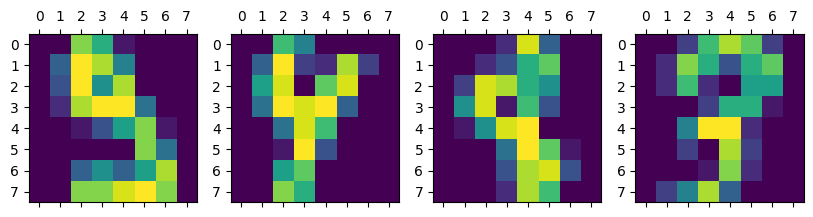

In [4]:
print(f'Accuracy of the best classifier and hyperparameters: {best_classifier.score(X_test, y_test):.3}')

y_hat = best_classifier.predict(X_test)
M = metrics.confusion_matrix(y_true=y_test, y_pred=y_hat)
df = pd.DataFrame(data=M)
print(f'df:\n{df}')

# get the index of mis-predicition, combine X_test, y_test, y_hat as a dataframe, find the index where y_test != y_hat
df_test = pd.DataFrame(data=[y_test, y_hat], index=['test', 'pred'])
df_test = df_test.T
df_test.head()
print(f'\nIndex of the wrong predictions in test data (test represents the original labels in test data, pred means the predicted labels)')
print(df_test[df_test.test != df_test.pred])

# Plotting, remeber to reshape each row in to a new square matrix
wrong_pred_idx = list(df_test[df_test.test != df_test.pred].index.to_numpy())
# print(wrong_pred_idx)
# print(X[61:62,:].reshape(8,8))

# Print each plot of wrong predicted digits by looping through
fig = plt.figure(figsize=(10, 5)) # new blank figure
gs = fig.add_gridspec(nrows=1, ncols=4)
for i in range(0,4):
    # The subplot row is i's first digit and the column is i's second digit.
    # divided by ncols from fig.add_gridspec
    ax = fig.add_subplot(gs[i // 4, i % 4])
    ax.matshow(X_test[wrong_pred_idx[i]].reshape(8, 8))

## 2. One-class classification (outlier detection)

### 2(a) There is an old gradebook of mine at [http://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt](http://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt).
Use `pd.read_table()` to read it into a DataFrame.

Hint: `pd.read_table()` has many parameters. Check its documentation to find three parameters to:
- Read from the given URL
- Use the separator '\s+', which means 'one or more whitespace characters'
- Skip the first 12 rows, as they are a note to students and not part of the gradebook

In [6]:
df = pd.read_table(filepath_or_buffer='https://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt',
                   sep='\s+', skiprows=12)

### Use `clf = mixture.GaussianMixture(n_components=1)` to make a one-class Gaussian model to decide which $\mathbf{x}=(\text{Exam1}, y=\text{Exam2})$ are outliers:

- Set a matrix X to the first two columns, Exam1 and Exam2.
- These exams were worth 125 points each. Transform scores to percentages in $[0, 100]$.

  Hint: I tried the MinMaxScaler() first, but it does the wrong thing if there aren't scores
  of 0 and 125 in each column. So I just multiplied the whole matrix by 100 / 125.
- Fit your classifier to X.
  
  - The reference page for `mixture.GaussianMixture` includes a `fit(X, y=None)` method
    with the comment that y is ignored (as this is an unsupervised learning algorithm--there
    is no $y$) but present for API consistency. So we can fit with just X.
  - I got a warning about "KMeans ... memory leak". You may ignore this
    warning if you see it. I still got satisfactory results.
- Print the center $\mathbf{\mu}$ and covariance matrix $\mathbf{\Sigma}$ from the two-variable
  $N_2(\mathbf{\mu}, \mathbf{\Sigma})$ distribution you estimated.

In [7]:
X = df[['Exam1', 'Exam2']]
X = X/125 * 100

clf = mixture.GaussianMixture(n_components=1)
# unsupervised learning algorithm
clf.fit(X)
print(f'The center is: {clf.means_}, the covariance matrix is: \n{clf.covariances_}')

The center is: [[82.81329923 71.01176471]], the covariance matrix is: 
[[[155.51123078  73.02961336]
  [ 73.02961336 180.87014392]]]


### Make a contour plot of the negative log likelihood $-\ln f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ for $\mathbf{X} \sim N_2(\mathbf{\mu}, \mathbf{\Sigma})$, provided you have set `clf`.

```
# make contour plot of log-likelihood of samples from clf.score_samples()
margin = 10
x = np.linspace(0 - margin, 100 + margin)
y = np.linspace(0 - margin, 100 + margin)
grid_x, grid_y = np.meshgrid(x, y)
two_column_grid_x_grid_y = np.array([grid_x.ravel(), grid_y.ravel()]).T
negative_log_pdf_values = -clf.score_samples(two_column_grid_x_grid_y)
grid_z = negative_log_pdf_values
grid_z = grid_z.reshape(grid_x.shape)
plt.contour(grid_x, grid_y, grid_z, levels=10) # X, Y, Z
plt.title('(Exam1, Exam2) pairs')
```

Paste my code into your code cell below and add more code:
- Add black $x$- and $y$- axes. Label them Exam1 and Exam2.
- Plot the data points in blue.
- Plot $\mathbf{\mu}=$ `clf.means_` as a big lime dot.
- Overplot (i.e. plot again) in red the 8 outliers determined by a threshold consisting
  of the 0.02 quantile of the pdf values $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$
  for each $\mathbf{x}$ in X.
  
  Hint: `clf.score_samples(X)` gives log likelihood, so `np.exp(clf.score_samples(X))`
  gives the required $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ values.

D:\python3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


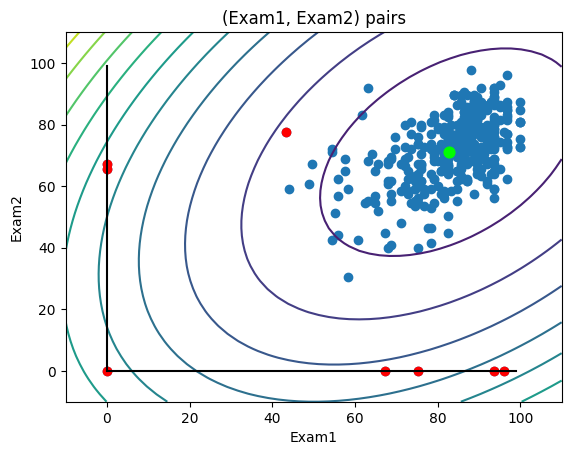

In [8]:
# make contour plot of log-likelihood of samples from clf.score_samples()
margin = 10
x = np.linspace(0 - margin, 100 + margin)
y = np.linspace(0 - margin, 100 + margin)
grid_x, grid_y = np.meshgrid(x, y)
two_column_grid_x_grid_y = np.array([grid_x.ravel(), grid_y.ravel()]).T
negative_log_pdf_values = -clf.score_samples(two_column_grid_x_grid_y)
grid_z = negative_log_pdf_values
grid_z = grid_z.reshape(grid_x.shape)
plt.contour(grid_x, grid_y, grid_z, levels=10) # X, Y, Z
plt.title('(Exam1, Exam2) pairs')

# More codes start from here
plt.xlabel('Exam1')
plt.ylabel('Exam2')
dots = range(0,100)
plt.plot(dots, [0]*100, 'black')
plt.plot([0]*100, dots, 'black')
plt.scatter(X['Exam1'], X['Exam2'])
means = list(clf.means_)
plt.scatter(means[0][0], means[0][1], s=60, c='lime')

# Overplot outliers
f_value = np.exp(clf.score_samples(X))
quantile = np.quantile(f_value, 0.02)
df_quantile = pd.DataFrame(data=f_value)
idx = list(df_quantile[df_quantile[0] < quantile].index.to_numpy())

for i in range(len(idx)):
    plt.scatter(X['Exam1'].loc[idx[i]], X['Exam2'].loc[idx[i]], c='red')
# print(idx)
# print(X.loc[357,:])
# print(X['Exam2'].loc[357])

### Write a little code to report whether, by the 0.02 quantile criterion, $\mathbf{x}=$ (Exam1=50, Exam2=100) is an outlier.

Compare $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ to your threshold

In [10]:
# ... your code here ...
likelihood = np.exp(clf.score_samples([[50, 100]]))
if (likelihood < quantile):
    print('data point Exam1=50, Exam2=100 is an outlier')
else:
    print('data point Exam1=50, Exam2=100 is not an outlier')

data point Exam1=50, Exam2=100 is an outlier


D:\python3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


## Explore the fact that accuracy can be misleading for imbalanced data.
Here I make a fake imbalanced data set by randomly sampling $y$ from a distribution with $P(y = 0) = 0.980$ and $P(y = 1) = 0.020$.

In [24]:
X, y = make_classification(n_samples=1000, n_features=4, n_classes=2, weights=[0.980, 0.020],
                           n_clusters_per_class=1, flip_y=0.01, random_state=0)
print(f'np.bincount(y)={np.bincount(y)}; we expect about 980 zeros and 20 ones.')
print(f'np.mean(y)={np.mean(y)}; we expect the proportion of ones to be about 0.020.')

np.bincount(y)=[973  27]; we expect about 980 zeros and 20 ones.
np.mean(y)=0.027; we expect the proportion of ones to be about 0.020.


Here I split the data into 50% training and 50% testing data.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0, stratify=y)
print(f'np.bincount(y_train)={np.bincount(y_train)}')
print(f'np.mean(y_train)={np.mean(y_train)}.')
print(f'np.bincount(y_test)={np.bincount(y_test)}.')
print(f'np.mean(y_test)={np.mean(y_test)}.')

np.bincount(y_train)=[486  14]
np.mean(y_train)=0.028.
np.bincount(y_test)=[487  13].
np.mean(y_test)=0.026.


### Train and assess a gradient boosting model.
- Train on the training data.
- Use 100 trees of maximum depth 1 and learning rate $\alpha = 0.25$.
- Use `random_state=0` (so that teacher, TAs, and students have a chance of
  getting the same results).
- Display the accuracy, precision, recall, and AUC on the test data. Use 3 decimal places.
  Use a labeled print statement with 3 decimal places so the reader can easily find each metric.
- Make an ROC curve from your classifier and the test data.

The accuracy score is: 0.982
The precision score is: 0.7
The recall score is: 0.538
The area under ROC curve is: 0.769


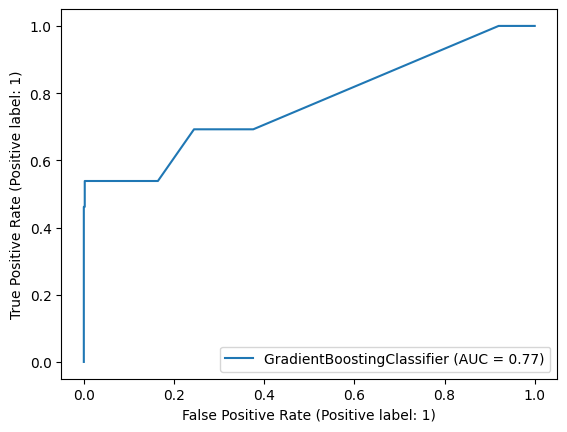

In [27]:
# Train on traning dataset
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.25, max_depth=1, random_state=0)
clf.fit(X_train, y_train)

# Display info based on test dataset
y_pred = clf.predict(X_test)
test_accuracy_score = clf.score(X_test, y_test) # Or use accuracy_score(y_true, y_pred)
precision_score = metrics.precision_score(y_true=y_test, y_pred=y_pred) # precision score
recall_score = metrics.recall_score(y_true=y_test, y_pred=y_pred) # recall score
# auc
probability_y_is_1 = clf.predict_proba(X_test)[:,1]
auc = metrics.roc_auc_score(y_true=y_test, y_score=probability_y_is_1) # Area Under ROC Curve

print(f'The accuracy score is: {test_accuracy_score:.3}')
print(f'The precision score is: {precision_score:.3}')
print(f'The recall score is: {recall_score:.3}')
print(f'The area under ROC curve is: {auc:.3}')

# Make ROC curve
metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test)

Note the high accuracy but lousy precision, recall, and AUC.

Note that since the data have about 98% $y = 0$, we could get about 98% accuracy
by just always predicting $\hat{y} = 0$. High accuracy alone is not necessarily helpful.

### Now oversample the data to get a balanced data set.
- Use the `RandomOverSampler(random_state=0)` to oversample and get a balanced data set.
- Repeat `train_test_split()` block from above.
- Repeat your train/assess block from above.

The accuracy score is: 0.957
The precision score is: 0.97
The recall score is: 0.942
The area under ROC curve is: 0.993


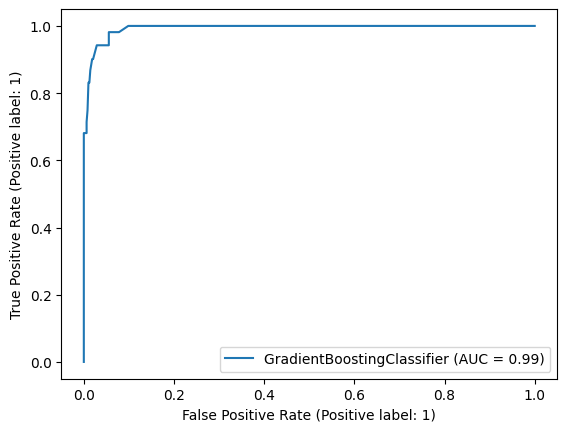

In [17]:
random_sampler = RandomOverSampler(random_state=0)
X_resampled, y_resampled = random_sampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.5, 
                                                    random_state=0, stratify=y_resampled)

# Training
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.25, max_depth=1, random_state=0)
clf.fit(X_train, y_train)

# Display info based on test dataset
y_pred = clf.predict(X_test)
test_accuracy_score = clf.score(X_test, y_test) # Or use accuracy_score(y_true, y_pred)
precision_score = metrics.precision_score(y_true=y_test, y_pred=y_pred) # precision score
recall_score = metrics.recall_score(y_true=y_test, y_pred=y_pred) # recall score
# auc
probability_y_is_1 = clf.predict_proba(X_test)[:,1] # find out prob of 0 or 1? See Piazza for answer
auc = metrics.roc_auc_score(y_true=y_test, y_score=probability_y_is_1) # Area Under ROC Curve

print(f'The accuracy score is: {test_accuracy_score:.3}')
print(f'The precision score is: {precision_score:.3}')
print(f'The recall score is: {recall_score:.3}')
print(f'The area under ROC curve is: {auc:.3}')

# Make ROC curve
metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test)

Note that we traded a little accuracy for much improved precision, recall, and AUC.

If you do classification in your project and report accuracy, please
also report the proportions of $y = 0$ and $y = 1$ in your test data so that
we get insight into whether your model improves upon always guessing $\hat{y} = 0$
or always guessing $\hat{y} = 1$.